 Worksheet 6

   Name: Ujjwol Bahadur Magar

   University ID: 2331426


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- Basic Setup ---
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, UnidentifiedImageError
import random


Dataset Path and Class Names

In [3]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/FruitinAmazon/train"

class_names = sorted(os.listdir(train_dir))
print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Check for Corrupted Images

In [4]:
corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

print(f"\nCorrupted Images: {corrupted_images}" if corrupted_images else "No corrupted images found.")


No corrupted images found.


Class Balance

In [5]:
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:\n" + "="*45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")



Class Distribution:
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


Visualize Random Samples

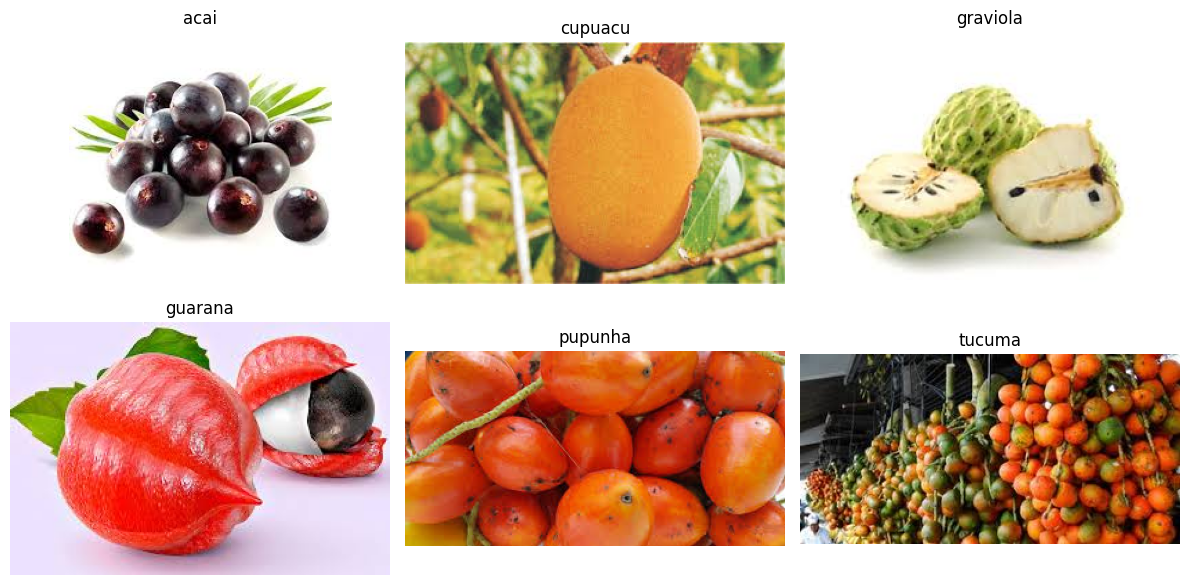

In [6]:
selected_images, selected_labels = [], []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        selected_images.append(os.path.join(class_path, random.choice(images)))
        selected_labels.append(class_name)

# Plot
cols = (len(selected_images) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = Image.open(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
plt.tight_layout()
plt.show()


Load Dataset with Split

In [8]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


 Data Augmentation

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Full Model with BN & Dropout

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Lambda, Rescaling)

model = Sequential([
    Lambda(data_augmentation, input_shape=(224, 224, 3)),
    Rescaling(1./255),

    Conv2D(32, (3,3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,711,302 (98.08 MB)

 Trainable params: 25,710,854 (98.08 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2452 - loss: 2.0367 - val_accuracy: 0.3333 - val_loss: 1.8167
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5503 - loss: 1.2374 - val_accuracy: 0.2222 - val_loss: 1.7252
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6367 - loss: 1.0280 - val_accuracy: 0.2222 - val_loss: 1.7621
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6502 - loss: 0.9564 - val_accuracy: 0.3333 - val_loss: 1.7775
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6476 - loss: 0.8853 - val_accuracy: 0.2778 - val_loss: 1.8046
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.6819 - loss: 0.7949 - val_accuracy: 0.2222 - val_loss: 1.8453
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7214 - loss: 0.7525 - val_accuracy: 0.2222 - val_loss: 1.8851
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.7352 - loss: 0.7773 - val_accuracy: 0.2222 - val_loss: 1.9540
Epoch 9/

Transfer Learning with VGG16

Import Required Libraries

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report
import numpy as np


Load and Prepare the Dataset

In [16]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/FruitinAmazon/train"
image_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


Preprocess Dataset

In [17]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Apply preprocessing to the datasets
def preprocess(images, labels):
    return preprocess_input(images), labels

train_ds = train_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)


Load VGG16 (Frozen)

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Add Custom Classification Head

In [19]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

Compile and Train

In [20]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 23s/step - accuracy: 0.2904 - loss: 5.2165 - val_accuracy: 0.5000 - val_loss: 3.7059
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 70s 18s/step - accuracy: 0.7522 - loss: 1.8151 - val_accuracy: 0.8333 - val_loss: 0.5246
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 92s 23s/step - accuracy: 0.9705 - loss: 0.2095 - val_accuracy: 0.7778 - val_loss: 1.1207
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 77s 18s/step - accuracy: 0.9340 - loss: 0.2444 - val_accuracy: 0.7778 - val_loss: 1.1961
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 58s 19s/step - accuracy: 0.9891 - loss: 0.0753 - val_accuracy: 0.7778 - val_loss: 0.9704


Evaluate and Generate Classification Report

In [21]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Classification Report:

              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         3
     cupuacu       1.00      1.00      1.00         4
    graviola       1.00      1.00      1.00         1
     guarana       1.00      1.00      1.00         3
     pupunha       0.57      1.00      0.73         4
      tucuma       0.67      0.67      0.67         3

    accuracy                           0.78        18
   macro avg       0.71      0.78      0.73        18
weighted avg       0.68      0.78      0.72        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Performance Summary:

The VGG16 transfer learning model achieved 78% accuracy on the validation set.

While most classes were predicted accurately (e.g., cupuacu, graviola, guarana), the model failed to predict the "acai" class at all — likely due to class imbalance or limited data. This is a common issue in small datasets.

Overall, the performance using transfer learning is better than our custom CNN model and shows the advantage of using pre-trained models.
